# Here i will show how you can use Plumed built in CV module to implement the middle latent space of an Autoencoder network as a collective variable!

[Plumed](plumed.github.io) is a powerful library used for running enhanced sampling simulations. It implements an very robust Collective variable module. Here I will show that you can implement a 3-layered neural network inside Plumed using its built in functions. This is possible because simpler networks are a series of linear/affine transforms 
$$y= W^Tx +b$$
plus non-linear layers(sigmoid here) 
$$\sigma(x) = \frac{1}{1+e^{-x}} $$

Both of these operations can be evaluated using the matheval library inside Plumed (skip to the end if you want the actual code)

# First an introduction to our model sysetem: Alanine dipeptide

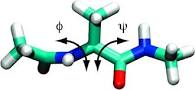

In [1]:
from IPython.display import Image
Image(filename='./helper_func/ala.jpeg')
#Image is copied from https://www.cp2k.org/_media/exercises:2014_ethz_mmm:alanine.png

In [10]:
from msmbuilder.featurizer import DihedralFeaturizer
%pylab inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', palette='colorblind')
sns.set_context('talk',1.3)
import numpy as np
import mdtraj as md
import sys
sys.path.insert(0, "helper_func")
%load_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


# We generated an intial 180ns trajectory to train the autoencoder

In [13]:
traj = md.load("../alanine_data/trajectory.dcd",top="../alanine_data/0.pdb").remove_solvent()


We will use the backbone dihedral features with sin-cosine transform as inputs into our nework. This leads to each simultion frame being represeneted by 4 features. 

In [14]:
f=DihedralFeaturizer(sincos=True)

# the non sin-cosine-transformed features are for visualization ONLY
plot_feat = DihedralFeaturizer(sincos=False).transform([traj])[0]
features = f.transform([traj])[0]
df = pd.DataFrame(f.describe_features(traj))


We can take a look at these features

In [15]:
features

array([[-0.83671731,  0.54763508,  0.87201053, -0.48948711],
       [-0.94203842,  0.3355051 ,  0.35030857, -0.93663436],
       [-0.71747822, -0.69658095,  0.02026244, -0.99979472],
       ..., 
       [-0.83257627, -0.55391043,  0.22891366,  0.97344673],
       [-0.96025288,  0.27913153, -0.07635421,  0.99708074],
       [-0.54195648, -0.8404066 ,  0.42633373,  0.90456593]], dtype=float32)

 And understand how they were calculated . For exampled feature 0 is the sin tranform of the dihedral connecting atoms [4 6 8 14]

In [16]:
df


,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[4, 6, 8, 14]",phi,Dihedral,sin,"[0, 1]","[ALA, ACE]","[1, 2]"
1,"[4, 6, 8, 14]",phi,Dihedral,cos,"[0, 1]","[ALA, ACE]","[1, 2]"
2,"[6, 8, 14, 16]",psi,Dihedral,sin,"[1, 2]","[ALA, NME]","[2, 3]"
3,"[6, 8, 14, 16]",psi,Dihedral,cos,"[1, 2]","[ALA, NME]","[2, 3]"


And use the un-transformed featres to plot. Each point on this scatter plot represents, a different simulation frame

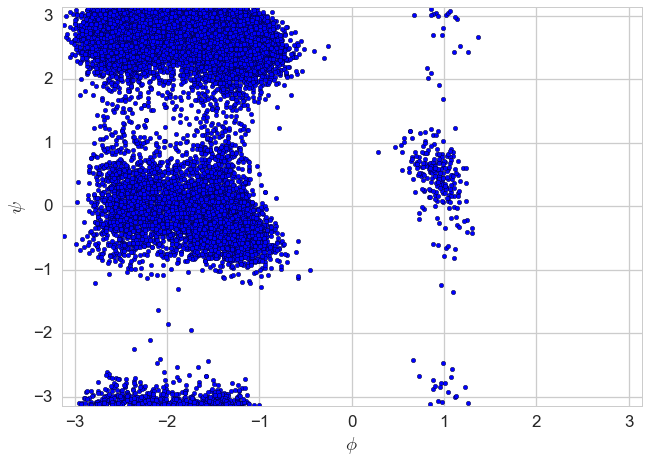

In [17]:
scatter(plot_feat[:,0],plot_feat[:,1])
xlim([-np.pi,np.pi])
ylim([-np.pi,np.pi])
xlabel(r'$\phi$')
ylabel(r'$\psi$')


#  Now begins the fun neural network part. Lets start by desiging a 3 layer autoencoder with a sigmoid non-linearity 

An autoencoder neural network is an unsupervised learning algorithm that tries to learn a latent space for its input. 
This is done by setting the output to the input. Thus the network tries to learn an identity function. 


We can now use this information, and restrict the middle layers of the encoding network to a singular value to learn the most salient features of the data. More importantly, we can use enhance sampling techniques such as metadynamics on this hidden layer to more efficiently sample alanine dipeptide. 

In [18]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

from torch import optim

# Hyper Parameters 
input_size = 4
hidden_size = 8
# The output class becomes our Plumed collective variable(CV)
num_classes = 1


In [19]:


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.df = df 
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_classes = num_classes

        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Sigmoid()
        self.l3 = nn.Linear(hidden_size, num_classes)     
    
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        return out
    
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(num_classes, hidden_size)
        self.l2 = nn.Sigmoid()
        self.l3 = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        return out
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.fc1 = Encoder()
        self.fc2 = Decoder()

    def forward(self, x):
        return self.fc2(self.fc1(x))

    

In [20]:
import os

In [21]:
if os.path.isfile("./autoencoder.net"):
    model = torch.load("./autoencoder.net")
else:
    model = AutoEncoder()    

In [22]:
all_x = Variable(torch.from_numpy(features))

In [ ]:
# setup sampler and loss

In [136]:
rnd_sampler = torch.utils.data.sampler.BatchSampler(features, batch_size=500,drop_last=False)

In [137]:
loss = nn.MSELoss()

# Train our autoencoder

In [138]:
optimizer = optim.Adam(model.parameters(), lr=0.5)
loss_list=[]
for epoch in range(5):
    for i in rnd_sampler:
        optimizer.zero_grad()
        
        x = Variable(torch.from_numpy(np.vstack(i)))
        y=model(x)
        output = loss(y,x) 
        output.backward()
        loss_list.extend(output.data.tolist())
        optimizer.step()

    

In [29]:
# Our auto-encoder is able learn the space rather well after only a epochs. 

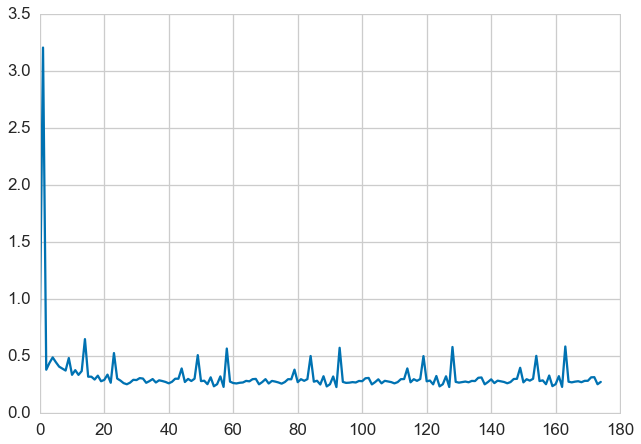

In [139]:
plot(loss_list)

In [30]:
new_y = model.fc1.forward(all_x)

# For example our original trajecotry has 2 transitions that show as high values in the auto-encoder's middle layer

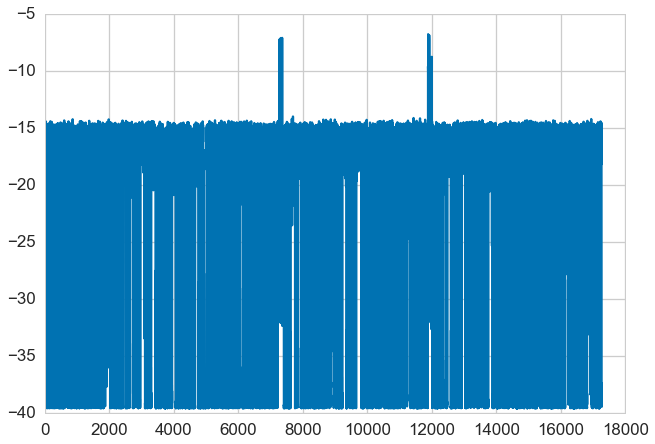

In [32]:
plot(new_y.data.tolist())

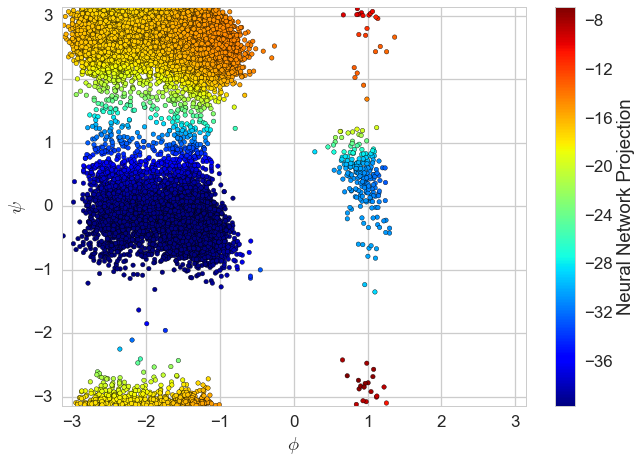

In [33]:
scatter(plot_feat[:,0],plot_feat[:,1],c=new_y.data.tolist(),cmap='jet')
xlim([-np.pi,np.pi])
ylim([-np.pi,np.pi])
cb = plt.colorbar()
xlabel(r'$\phi$')
ylabel(r'$\psi$')
cb.set_label("Neural Network Projection")


# Now I will show how we can use the auto-encoder's encoder network as a CV for input in Plumed 

This is done by  writiting the 3 layered encoder network into Plumed using a series of vector operations + exponential transforms. The full functions are given in the helper_func folder

In [35]:
from helper_func.helper import *

In [36]:
model.fc1.df = df

First the results!

In [38]:
print(render_network(model.fc1))

TORSION ATOMS=5,7,9,15 LABEL=phi_0_1 
TORSION ATOMS=7,9,15,17 LABEL=psi_1_2 
MATHEVAL ARG=phi_0_1 FUNC=sin(x) LABEL=l00 PERIODIC=NO 
MATHEVAL ARG=phi_0_1 FUNC=cos(x) LABEL=l01 PERIODIC=NO 
MATHEVAL ARG=psi_1_2 FUNC=sin(x) LABEL=l02 PERIODIC=NO 
MATHEVAL ARG=psi_1_2 FUNC=cos(x) LABEL=l03 PERIODIC=NO 
COMBINE LABEL=l10nb ARG=l00,l01,l02,l03 COEFFICIENTS=-1.1280087232589722,-1.4869011640548706,-1.7586259841918945,4.452581882476807 PERIODIC=NO 
MATHEVAL ARG=l10nb FUNC=x+0.605137825012207 LABEL=l10 PERIODIC=NO 
COMBINE LABEL=l11nb ARG=l00,l01,l02,l03 COEFFICIENTS=-0.5375660061836243,-1.2849867343902588,-1.8688691854476929,4.414360523223877 PERIODIC=NO 
MATHEVAL ARG=l11nb FUNC=x+0.7087084650993347 LABEL=l11 PERIODIC=NO 
COMBINE LABEL=l12nb ARG=l00,l01,l02,l03 COEFFICIENTS=-0.24642406404018402,-0.20244349539279938,-3.260493755340576,3.9347503185272217 PERIODIC=NO 
MATHEVAL ARG=l12nb FUNC=x+-0.3410336375236511 LABEL=l12 PERIODIC=NO 
COMBINE LABEL=l13nb ARG=l00,l01,l02,l03 COEFFICIENTS=-4.23934

# This is possible due to the modular design of computational graphs

This is possible because neural networks are highly sequential, and can be programatically written up to depend on the
outputs of their parent nodes. 

Therefore all we need to do is decide what type of layer we are on and call the appropriate function that will generate the appropriate code. Forexample, 

MATHEVAL ARG=l16 FUNC=1/(1+exp(-x)) LABEL=l26

does a sigmoid transform on the input of 6th neuron of the second layer( L-2-6 = L26). Its input is the ouput of the 6th neuron in the first layer ( L-1-6)

# To actually run Metadynamics, we need to add the following two lines at the end 



METAD ARG=l30 SIGMA=0.2 HEIGHT=1 BIASFACTOR=20 TEMP=300 FILE=HILLS PACE=1000 LABEL=metad 

PRINT ARG=l30,metad.bias STRIDE=1000 FILE=BIAS.0

The full file is given in plumed_autoencoder.dat, and can be used as regular input for sampling. 


# It is much faster to use GPUs for running simulations, so the actual simulation code is not presented it. However, they are vanilla NPT dynamics run for about 4.5ns.

# Visualizing the results

In [39]:
plumed_traj = md.load("../plumed_traj_2/trajectory.dcd",top="../plumed_traj_2/starting_coordinates/0.pdb")


In [40]:
plumed_traj_feat = DihedralFeaturizer(sincos=True).transform([plumed_traj])[0]
plumed_traj_plot_feat = DihedralFeaturizer(sincos=False).transform([plumed_traj])[0]


In [41]:
x_plumed = Variable(torch.from_numpy(plumed_traj_feat))
y_plumed = model.fc1(x_plumed)
nn_y_plumed = np.array(y_plumed.data.tolist())[:,0]


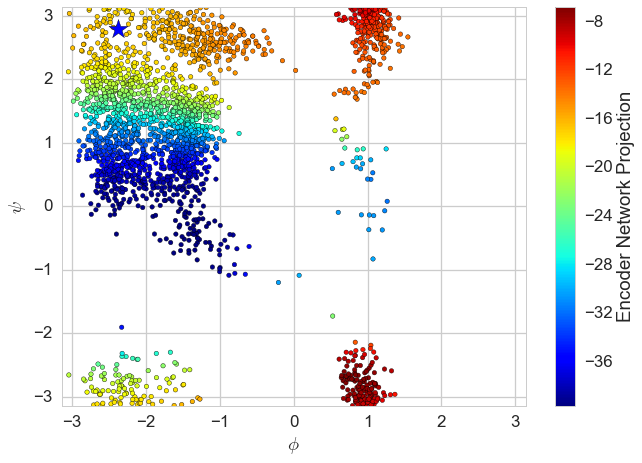

In [52]:
scatter(plumed_traj_plot_feat[0,0],plumed_traj_plot_feat[0,1],s=400,marker='*',zorder=100)
scatter(plumed_traj_plot_feat[:,0],plumed_traj_plot_feat[:,1],c=nn_y_plumed,cmap='jet')
xlim([-np.pi,np.pi])
ylim([-np.pi,np.pi])
cb = colorbar()
xlabel(r'$\phi$')
ylabel(r'$\psi$')
cb.set_label("Encoder Network Projection")


In [53]:
# the large blue star is the starting structure

# We can visualize both the regular MD trajectory and the metadynamics trajctory to see how using a deep collective variable significantly improves the sampling efficiency our alanine dipeptide

(-40, -5)

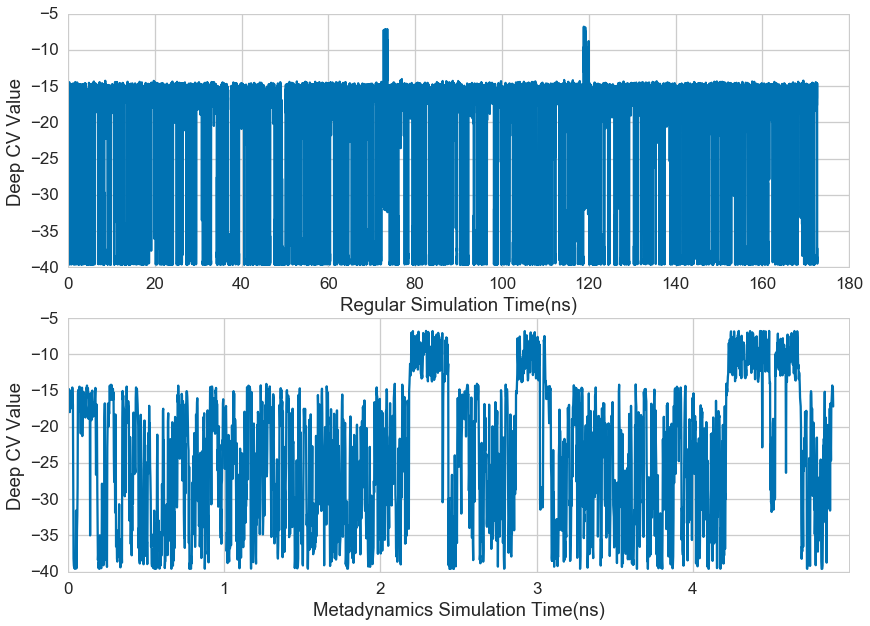

In [173]:
figure(figsize=(14,10))
subplot(2,1,1)
plot(new_y.data.tolist())
# msmbuilder ala sims are saved every ps
xticks([0,2000,4000,6000,8000,10000,12000,14000,16000,18000],[0,20,40,60,80,100,120,140,160,180])
ylim([-40,-5])
xlabel("Regular Simulation Time(ns)")
ylabel("Deep CV Value")

subplot(2,1,2)
plot(nn_y_plumed)
# our plumed sims are saved every 2ps 
xticks([0,500,1000,1500,2000],[0,1,2,3,4])
xlabel("Metadynamics Simulation Time(ns)")
ylabel("Deep CV Value")
ylim([-40,-5])


# Note that the x-axis is almost 36 times smaller than in the bottom panel. Thus we see 2x cross-overs in 1/36 the amount of simulations, making the overall simulation ~72x faster than regular sampling. 